In [ ]:
import numpy as np
import hashlib

# --- Von Neumann extractor ---
def von_neumann_extraction(folded_bits):
    extracted_bits = []
    for i in range(0, len(folded_bits) - 1, 2):
        pair = folded_bits[i], folded_bits[i + 1]
        if pair == (0,1) or pair == (1,0):
            extracted_bits.append(folded_bits[i])
    return np.array(extracted_bits)

# --- Convert bits to bytes ---
def bits_to_bytes(bits): 
    pad_len = (8 - len(bits) % 8) % 8
    bits_padded = np.concatenate((bits, np.zeros(pad_len, dtype=int)))
    return np.packbits(bits_padded).tobytes()

# --- SHA256 extractor ---
def sha256_extractor(bits):
    block_size = 256
    final_bits = []
    for i in range(0, len(bits), block_size):
        block = bits[i:i + block_size]
        if len(block) < block_size:
            break
        hash_bytes = hashlib.sha256(bits_to_bytes(block)).digest()
        hash_bits = np.unpackbits(np.frombuffer(hash_bytes, dtype=np.uint8))
        final_bits.extend(hash_bits[:block_size])
    return np.array(final_bits)

# --- Generate raw bits from noise ---
def generate_bits():
    dt = 0.001
    t = np.arange(0, 15000, dt) 
    f = 2.5 * np.random.randn(len(t))
    n = len(t)
    fhat = np.fft.fft(f, n)
    PSD = fhat * np.conj(fhat) / n

    threshold = np.median(PSD)
    bits = (PSD > threshold).astype(int)
    half = len(bits) // 2
    folded_bits = bits[:half] ^ bits[half:half*2]

    return von_neumann_extraction(folded_bits)

# --- Generate single digit (0-9) ---
def generate_single_digit():
    raw_bits = generate_bits()
    final_bits = sha256_extractor(raw_bits)

    if len(final_bits) < 4:
        raise ValueError("Not enough bits generated.")

    rand_int = int(''.join(map(str, final_bits[:4])), 2)
    single_digit = rand_int % 10
    return single_digit

# --- Generate multiple digits ---
def generate_multiple_digits(N):
    digits = [generate_single_digit() for _ in range(N)]
    return np.array(digits)


5


Current error: 1.3638079012812616
Current number of layers: 0
Current error: 1.3638079012812616
Current number of layers: 0


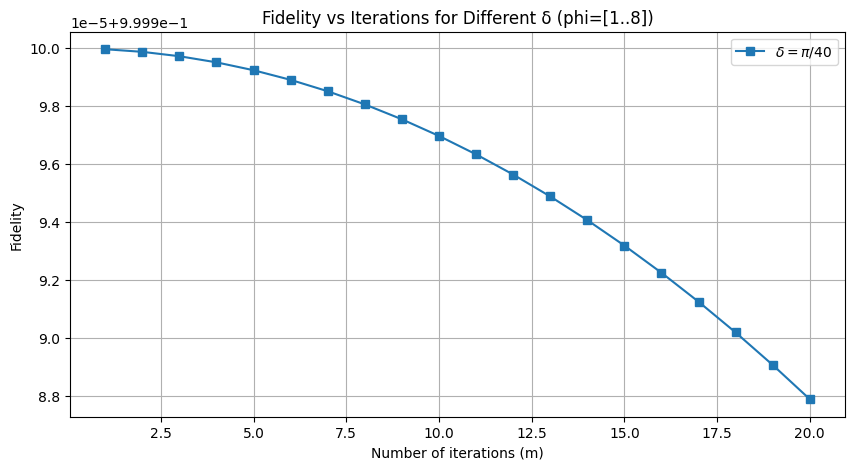

In [ ]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# --- define psi and phi ---
psi = [1, 2, 3, 4, 5, 6, 7, 8]        # initial psi vector
phi = [1, 2, 3, 4, 5, 6, 7, 8]        # phi for programmable phase

N = 8
n = 3                    # number of qubits (log2 of vector length)
number_of_layers = 2     # layers for MPS initialization

# --- create normalized QuantumState objects ---
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)

# --- generate MPS initializer circuits ---
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()

# --- protocol function ---
def run_protocol(m, delta):
    psi_reg = QuantumRegister(n, name="ψ")
    phi_reg = QuantumRegister(n, name="φ")
    creg = ClassicalRegister(n, name="c")
    qc = QuantumCircuit(psi_reg, phi_reg, creg)

    # initialize states
    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    # iterative protocol
    for k in range(1, m+1):
        # CNOT flags
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

        # apply small phase
        qc.mcp(delta, psi_reg[0:-1], psi_reg[-1])

        # uncompute flags
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        # uncompute φ, measure, reset
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, creg)
        qc.reset(phi_reg)

        if k < m:
            qc.append(U_phi, phi_reg)

    # simulate
    sim = AerSimulator()
    qc.save_statevector()
    result = sim.run(transpile(qc, sim)).result()
    full_state = result.get_statevector(qc)

    # reduced density matrix for ψ
    rho_psi = partial_trace(full_state, list(range(n, 2*n)))

    # Ideal target vector with programmable phase
    psi_vec = np.array(psi) / np.linalg.norm(psi)
    phi_vec = np.array(phi) / np.linalg.norm(phi)
    phase_profile = np.exp(1j * delta * m * np.abs(phi_vec)**2)
    ideal_vec = psi_vec * phase_profile
    rho_ideal = DensityMatrix(ideal_vec)

    # fidelity
    fid = state_fidelity(rho_psi, rho_ideal)
    return fid

# --- run for multiple iterations ---
m_values = list(range(1, 21))

#fidelity for delta = pi/4
delta0 = np.pi / 4
fidelities0 = [run_protocol(m, delta0) for m in m_values]

# fidelity for delta = pi/40
delta1 = np.pi / 40
fidelities1 = [run_protocol(m, delta1) for m in m_values]

# fidelity for delta = pi/400
delta2 = np.pi / 400
fidelities2 = [run_protocol(m, delta2) for m in m_values]

# fidelity for delta = pi/4000
delta3 = np.pi / 4000
fidelities3 = [run_protocol(m, delta3) for m in m_values]

# --- plot results ---
plt.figure(figsize=(10,5))
plt.plot(m_values, fidelities0, 'o-', label=r'$\delta = \pi/4$')
plt.plot(m_values, fidelities1, 's-', label=r'$\delta = \pi/40$')
plt.plot(m_values, fidelities2, '^-', label=r'$\delta = \pi/400$')
plt.plot(m_values, fidelities3, 'x-', label=r'$\delta = \pi/4000$')
plt.xlabel("Number of iterations (m)")
plt.ylabel("Fidelity")
plt.title("Fidelity vs Iterations for Different δ (phi=[1..8])")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(m_values, fidelities0, 'o-', label=r'$\delta = \pi/4$')
plt.plot(m_values, fidelities1, 's-', label=r'$\delta = \pi/40$')
plt.plot(m_values, fidelities2, '^-', label=r'$\delta = \pi/400$')
plt.plot(m_values, fidelities3, 'x-', label=r'$\delta = \pi/4000$')
plt.xlabel("Number of iterations (m)")
plt.ylabel("Fidelity")
plt.title("Fidelity vs Iterations for Different δ (phi=[1..8])")
plt.ylim(0.999, 1.0)  # zoom in to see small differences
plt.legend()
plt.grid(True)
plt.show()
